In [1]:
import gymnasium as gym
import numpy as np
from gymnasium.wrappers import TimeLimit # Add this line
import matplotlib.pyplot as plt
from IPython.display import  display, clear_output

In [2]:
env = gym.make("MountainCar-v0",render_mode="rgb_array")

In [3]:
state, _ = env.reset()
n_bins = 20 

q_table = np.zeros((n_bins, n_bins, env.action_space.n))

In [4]:
def discretize_state(state):
    position, velocity = state
    pos_bin = int(np.digitize(position, np.linspace(-1.2, 0.6, n_bins)) - 1)
    vel_bin = int(np.digitize(velocity, np.linspace(-0.07, 0.07, n_bins)) - 1)
    return pos_bin, vel_bin

In [5]:
learning_rate = 0.1
discount_factor = 0.99
exploration_start = 1.0
exploration_end = 0.01
exploration_decay = 0.9995
episodes = 10000
epsilon = exploration_start

def choose_action(state, epsilon):
    if np.random.rand() < epsilon:
        return env.action_space.sample()  # Explore
    else:
        pos_bin, vel_bin = discretize_state(state)
        return np.argmax(q_table[pos_bin, vel_bin])  # Exploit

In [6]:
from tqdm import tqdm
for episode in tqdm(range(episodes)):
    state, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        pos_bin, vel_bin = discretize_state(state)
        action = choose_action(state, epsilon)

        next_state, reward, terminated, truncated, info = env.step(action)
        next_pos_bin, next_vel_bin = discretize_state(next_state)

        total_reward += reward

        # Update Q-value
        best_next_action = np.argmax(q_table[next_pos_bin, next_vel_bin])
        td_target = reward + discount_factor * q_table[next_pos_bin, next_vel_bin, best_next_action]
        td_error = td_target - q_table[pos_bin, vel_bin, action]
        q_table[pos_bin, vel_bin, action] += learning_rate * td_error

        state = next_state
        done = terminated or truncated

    epsilon = max(exploration_end, epsilon * exploration_decay)
    if episode % 1000 == 0:
        clear_output(wait=True)
        print(f"Episode {episode}, Total Reward: {total_reward}, Epsilon: {epsilon:.4f}")

print("Training completed.")
print("Final Q-table shape:\n", q_table.shape)
env.close()           

 90%|█████████ | 9007/10000 [04:42<00:32, 31.02it/s]

Episode 9000, Total Reward: -200.0, Epsilon: 0.0111


100%|██████████| 10000/10000 [05:09<00:00, 32.27it/s]

Training completed.
Final Q-table shape:
 (20, 20, 3)


Total reward during evaluation: -152.0


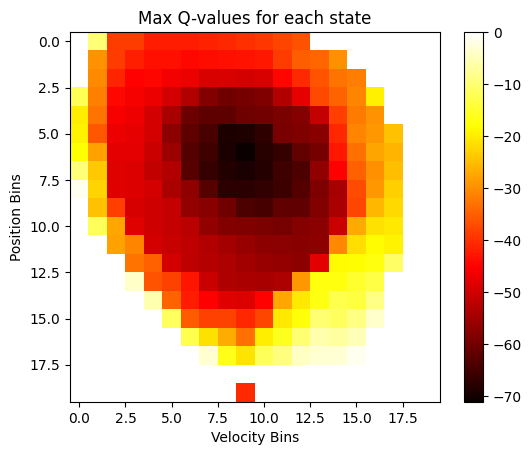

In [10]:
env = gym.make("MountainCar-v0",render_mode="human")
state, _ = env.reset()
done = False
total_reward = 0

while not done:
    pos_bin, vel_bin = discretize_state(state)
    action = np.argmax(q_table[pos_bin, vel_bin])
    next_state, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    state = next_state
    done = terminated or truncated

print(f"Total reward during evaluation: {total_reward}")

env.close()
plt.imshow(q_table.max(axis=2), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Max Q-values for each state")
plt.xlabel("Velocity Bins")
plt.ylabel("Position Bins")
plt.show()
